In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Работа с данными

Атрибутный состав данных

* text - Текст твита 
* keyword - Ключевое слово твита
* location - Место отправки твита

**Необходимо предсказать, написан ли твит о реальном происшествии или это фейк, метки классов соответсвенно 1 и 0.**

https://www.kaggle.com/c/nlp-getting-started/overview

## Загрузка данных

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


В данных много пропущенных значений, с ними надо что делать

## Баланс целевой величины

Посмотрим на баланс целевой величины

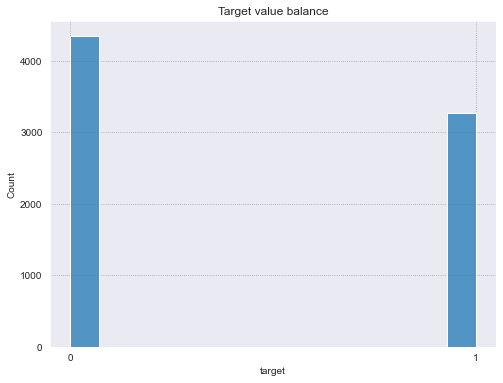

In [4]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=df_train, x='target')
plt.xticks([0,1])
plt.show()

В целом баланс хороший, но все таки лучше не использовать accuracy в данной задаче (баланс не 50 на 50). Будем сравнивать алгоритмы по метрике balanced accuracy. У некоторых алгоритмов есть параметр class_weights для несбалансированных данных. Если возможно, будем использовать class_weights = 'balanced'.

## Предобработка текста

In [5]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from functools import lru_cache

class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d #]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')


    def remove_URL(self, text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)


    def remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)


    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    def __call__(self, text):
        text = self.remove_URL(text)
        text = self.remove_html(text)
        text = self.remove_emoji(text)
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas) 

In [6]:
preprocessor = Text_preproc('english')

df_train['clear_text'] = df_train['text'].apply(preprocessor)
df_train.head()

,id,keyword,location,text,target,clear_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


In [7]:
pd.options.display.max_colwidth = 200

for i in range(3):
    print(f'FULL TEXT:\n\t{df_train.iloc[i].text}\nCLEAR TEXT:\n\t{df_train.iloc[i].clear_text}')

FULL TEXT:
	Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
CLEAR TEXT:
	deed reason #earthquake may allah forgive u
FULL TEXT:
	Forest fire near La Ronge Sask. Canada
CLEAR TEXT:
	forest fire near la ronge sask canada
FULL TEXT:
	All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
CLEAR TEXT:
	resident asked shelter place notified officer evacuation shelter place order expected


# Classic ML models Baseline

**В этой части были выбраны следующие алгоритмы:**

* Алгортим Наивного Байеса

* Линейные модели
    1. Метод опорных векторов с линейным ядром
    2. Логистическая регрессия


* Метрический алгортим k ближайших соседей

**Для представления текста используется TF-IDF**

In [8]:
X_train = np.array(df_train['clear_text'])
y_train = np.array(df_train['target'])

X_train.shape, y_train.shape

((7613,), (7613,))

## Train/val

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Validation shape: {X_val.shape, y_val.shape}')

Train shape: ((6090,), (6090,))
Validation shape: ((1523,), (1523,))


## TD-IDF Vectorizer

TF-IDF (TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

$$TF-IDF (t, d, D) =  TF(t, d) \cdot IDF(t, D)$$

где $d$ - отдельный документ, $t$ - cлово, $D$ - коллекция документов.

$$TF = \frac{n_t}{\sum{n_k}} $$

где $n_t$ - число вхождений слова в документ,  $\sum{n_k}$ - общее число слов в документе.

$$IDF = \log{\frac{|D|}{|\{d_i \in  D | t \in d_i \}|}}$$

где $|D|$ - число документов в коллекции, $|\{d_i \in  D | t \in d_i \}|$ - число документов из коллекции $D$, в которых встречается $t$.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

X_train = tfidf_vectorizer.fit_transform(X_train)

X_val = tfidf_vectorizer.transform(X_val)

X_train, X_val

(<6090x52791 sparse matrix of type '<class 'numpy.float64'>'
 	with 105744 stored elements in Compressed Sparse Row format>,
 <1523x52791 sparse matrix of type '<class 'numpy.float64'>'
 	with 15705 stored elements in Compressed Sparse Row format>)

## Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### Tuning

In [22]:
alpha_grid = np.linspace(1e-10, 3, 50)
scores = {}

for alpha in alpha_grid:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    scores[alpha] = balanced_accuracy_score(y_val, y_pred)

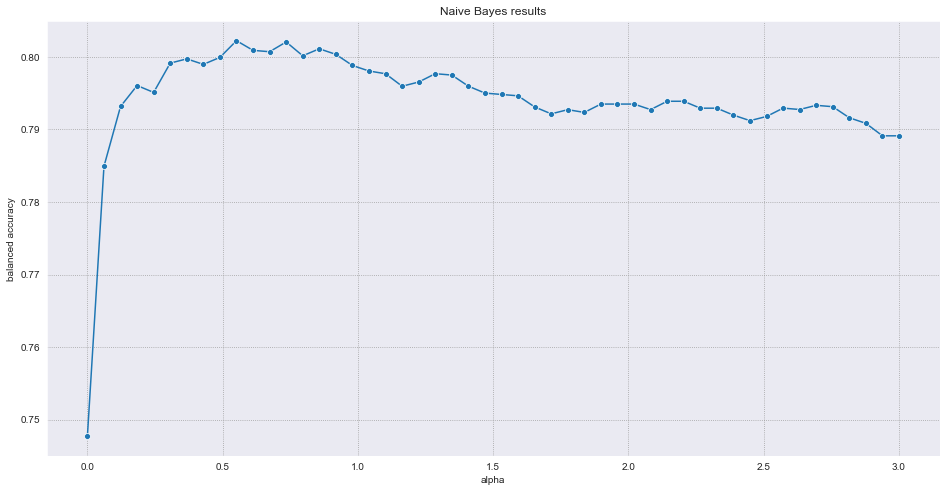

In [23]:
plt.figure(figsize=(16,8))
plt.title('Naive Bayes results')

sns.lineplot(x = scores.keys(), y = scores.values(), marker = 'o')

plt.xlabel('alpha')
plt.ylabel('balanced accuracy')
plt.show()

In [24]:
best_accuracy_key = max(scores, key=scores.get)
print(f'The best balanced accuracy is {scores[best_accuracy_key]} with params {best_accuracy_key}')

The best balanced accuracy is 0.8022156297617917 with params 0.551020408244898


### fit-predict

In [15]:
%%time

model = MultinomialNB(alpha=0.551020408244898)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Wall time: 11 ms


In [16]:
print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Blanced accuracy of the model: 0.8022156297617917


## Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### Tuning

In [18]:
C_grid = np.linspace(1e-10, 5, 50)
scores = {}

for C in C_grid:
    model = LogisticRegression(penalty='l2', C=C, class_weight='balanced', max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    scores[C] = balanced_accuracy_score(y_val, y_pred)

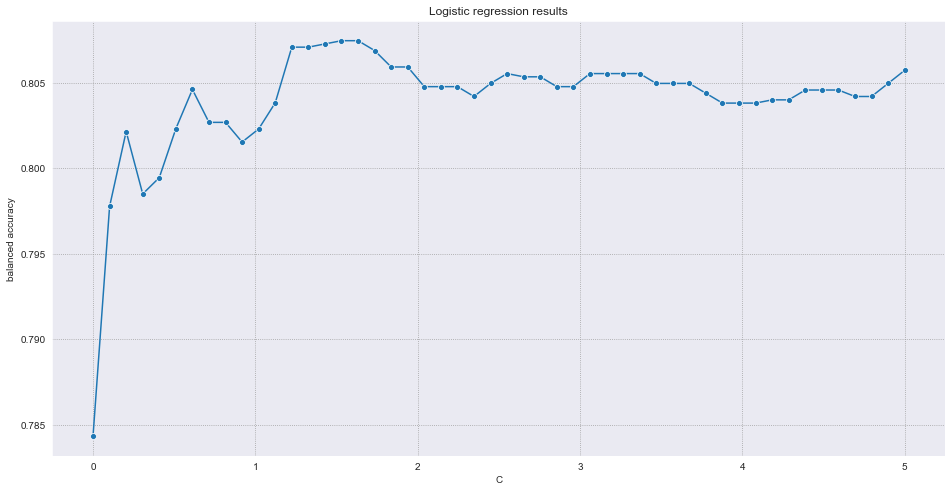

In [19]:
plt.figure(figsize=(16,8))
plt.title('Logistic regression results')

sns.lineplot(x = scores.keys(), y = scores.values(), marker = 'o')

plt.xlabel('C')
plt.ylabel('balanced accuracy')
plt.show()

In [20]:
best_accuracy_key = max(scores, key=scores.get)
print(f'The best balanced accuracy is {scores[best_accuracy_key]} with params {best_accuracy_key}')

The best balanced accuracy is 0.8074564598487488 with params 1.530612244967347


### fit-predict

In [21]:
%%time

model = LogisticRegression(penalty='l2', C=1.530612244967347, class_weight='balanced', max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Wall time: 889 ms


In [22]:
print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       869
           1       0.79      0.77      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Blanced accuracy of the model: 0.8074564598487488


## Linear SVC

In [23]:
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### Tuning

In [24]:
C_grid = np.linspace(1e-10, 5, 50)
scores = {}

for C in C_grid:
    model = LinearSVC(penalty='l2', C=C, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    scores[C] = balanced_accuracy_score(y_val, y_pred)

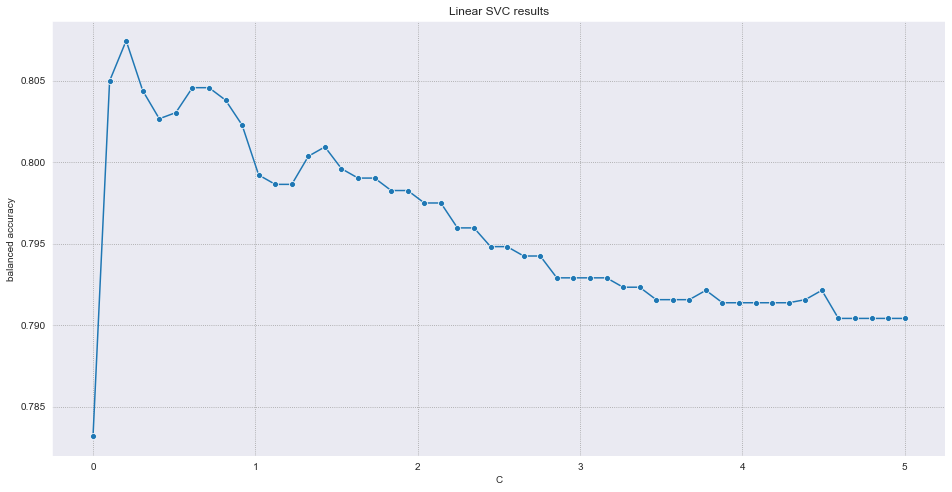

In [25]:
plt.figure(figsize=(16,8))
plt.title('Linear SVC results')

sns.lineplot(x = scores.keys(), y = scores.values(), marker = 'o')

plt.xlabel('C')
plt.ylabel('balanced accuracy')
plt.show()

In [26]:
best_accuracy_key = max(scores, key=scores.get)
print(f'The best balanced accuracy is {scores[best_accuracy_key]} with params {best_accuracy_key}')

The best balanced accuracy is 0.8074564598487488 with params 0.2040816327489796


### fit-predict

In [27]:
%%time

model = LinearSVC(penalty='l2', C=0.2040816327489796, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Wall time: 31.8 ms


In [28]:
print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       869
           1       0.79      0.77      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Blanced accuracy of the model: 0.8074564598487488


## KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### Tuning

In [30]:
n_neighbors_grid = np.arange(1, 100)
scores = {}

for n_neighbors in n_neighbors_grid:
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='cosine')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    scores[n_neighbors] = balanced_accuracy_score(y_val, y_pred)

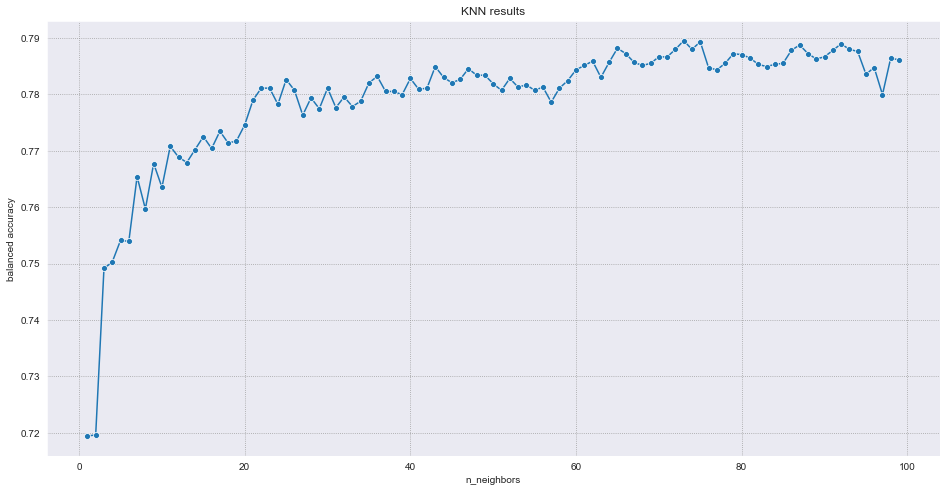

In [31]:
plt.figure(figsize=(16,8))
plt.title('KNN results')

sns.lineplot(x = scores.keys(), y = scores.values(), marker = 'o')

plt.xlabel('n_neighbors')
plt.ylabel('balanced accuracy')
plt.show()

In [32]:
best_accuracy_key = max(scores, key=scores.get)
print(f'The best balanced accuracy is {scores[best_accuracy_key]} with params {best_accuracy_key}')

The best balanced accuracy is 0.7895336479414984 with params 73


### fit-predict

In [33]:
%%time

model = KNeighborsClassifier(n_neighbors=73, weights='distance', metric='cosine')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Wall time: 474 ms


In [34]:
print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Blanced accuracy of the model: 0.7895336479414984


# Ensemble models Baseline

**Из анасамблевых методов были выбраны:**

* Случайный лес
* CatBoost (Градиентный бустинг)

**Для представления слов используется BagOfWords (CountVectorizer)**

In [17]:
X_train = np.array(df_train['clear_text'])
y_train = np.array(df_train['target'])

X_train.shape, y_train.shape

((7613,), (7613,))

## Train/val

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train,  y_val = train_test_split(df_train['clear_text'], df_train['target'],
                                                   test_size=0.2, stratify=df_train['target'], random_state=42)

print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Validation shape: {X_val.shape, y_val.shape}')

Train shape: ((6090,), (6090,))
Validation shape: ((1523,), (1523,))


## CountVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(ngram_range=(1,2))
X_train = bow_vectorizer.fit_transform(X_train)
X_val = bow_vectorizer.transform(X_val)

X_train, X_val

(<6090x52791 sparse matrix of type '<class 'numpy.int64'>'
 	with 105744 stored elements in Compressed Sparse Row format>,
 <1523x52791 sparse matrix of type '<class 'numpy.int64'>'
 	with 15705 stored elements in Compressed Sparse Row format>)

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### fit-predict

In [39]:
%%time

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

Wall time: 41.1 s


In [40]:
print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       869
           1       0.86      0.60      0.71       654

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523

Blanced accuracy of the model: 0.7632485580459103


## CatBoost

In [41]:
from catboost import CatBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

### fit-predict

In [42]:
model = CatBoostClassifier(learning_rate=0.1, loss_function= 'Logloss', iterations=1000, verbose= 100)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6832214	test: 0.6830084	best: 0.6830084 (0)	total: 494ms	remaining: 8m 13s
100:	learn: 0.5191767	test: 0.5254997	best: 0.5254997 (100)	total: 31.5s	remaining: 4m 40s
200:	learn: 0.4413947	test: 0.4738567	best: 0.4738567 (200)	total: 1m 2s	remaining: 4m 7s
300:	learn: 0.3983606	test: 0.4546492	best: 0.4546492 (300)	total: 1m 33s	remaining: 3m 36s
400:	learn: 0.3671694	test: 0.4440536	best: 0.4440536 (400)	total: 2m 4s	remaining: 3m 5s
500:	learn: 0.3459618	test: 0.4391931	best: 0.4390928 (495)	total: 2m 35s	remaining: 2m 34s
600:	learn: 0.3262301	test: 0.4344947	best: 0.4344381 (599)	total: 3m 6s	remaining: 2m 3s
700:	learn: 0.3101699	test: 0.4322900	best: 0.4321110 (689)	total: 3m 37s	remaining: 1m 32s
800:	learn: 0.2942155	test: 0.4296798	best: 0.4296798 (800)	total: 4m 8s	remaining: 1m 1s
900:	learn: 0.2805729	test: 0.4275277	best: 0.4273791 (888)	total: 4m 38s	remaining: 30.6s
999:	learn: 0.2682182	test: 0.4265671	best: 0.4265262 (997)	total: 5m 8s	remaining: 0us

bestTe

In [43]:
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(f'Blanced accuracy of the model: {balanced_accuracy_score(y_val, y_pred)}')

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Blanced accuracy of the model: 0.804485453771251


# Test Submissions

Уже обучены нужные представления слов

In [15]:
df_test = pd.read_csv('test.csv').drop(['id', 'keyword','location'], axis = 1)
df_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone."
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [16]:
preprocessor = Text_preproc('english')

df_test['clear_text'] = df_test['text'].apply(preprocessor)
df_test.head()

,text,clear_text
0,Just happened a terrible car crash,happened terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone.",heard #earthquake different city stay safe everyone
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose fleeing across street cannot save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting #spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [20]:
X_test = np.array(df_test['clear_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_bow = bow_vectorizer.transform(X_test)

## Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.551020408244898)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_tfidf)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [23]:
res = pd.read_csv('sample_submission.csv')
res['target'] = y_pred
res.to_csv('result_NB.csv', index = False)

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.530612244967347, class_weight='balanced', max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test_tfidf)

In [25]:
res = pd.read_csv('sample_submission.csv')
res['target'] = y_pred
res.to_csv('result_LogReg.csv', index = False)

## CatBoost

In [26]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(learning_rate=0.1, loss_function= 'Logloss', iterations=1000, verbose=False)
model.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred = model.predict(X_test_bow )

In [27]:
res = pd.read_csv('sample_submission.csv')
res['target'] = y_pred
res.to_csv('result_CatBoost.csv', index = False)